# AHT team IP info feature analysis
__Jennifer Wang, Staff Data Scientist, Wikimedia Foundation__  


September 2022

[Analysis ticket](https://phabricator.wikimedia.org/T313340) |  [Instrument spec]( 
https://docs.google.com/spreadsheets/d/16S5fqAEDz3A-Lu0rvtkiIgyeP_00ZX8qjz6GhH9fIlk/edit?usp=sharing)

# Table of Contents
1. [Introduction](#Introduction)  
2. [Is the information surfaced in IP Info useful?](#Is-the-information-surfaced-in-IP-Info-useful?)
3. [What is the usage of the popup on the different pages where it is exposed?](#What-is-the-usage-of-the-popup-on-the-different-pages-where-it-is-exposed?)
4. [Do people understand the information being shown?](#Do-people-understand-the-information-being-shown?)
5. [Who is the information shown most to?](#Who-is-the-information-shown-most-to?)
6. [Opt-in / opt-out](#Opt-in-/-opt-out)
7. [Other interesting findings](#Other-interesting-findings)

# Introduction

AHT team launched the IP info feature. This feature is to make it easier for admins, anti-vandal fighters and power users to access information about IP addresses. More details can be found on the [project page](https://meta.wikimedia.org/wiki/IP_Editing:_Privacy_Enhancement_and_Abuse_Mitigation/IP_Info_feature).  

Analysis measured the enrollment and the usage of IP info on all wiki projects to answer the question listed in [T313340](https://phabricator.wikimedia.org/T313340)

In [269]:
import wmfdata
wmfdata.utils.insert_code_toggle()

In [270]:
from wmfdata import hive
import pandas as pd

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

In [39]:
import numpy as np

# Is the information surfaced in IP Info useful?

Measurement is only for popups because we cannot measure accordion. Reason: Accordion is expanded or collapsed based on its previous status. Users can access IP info without clicking the accordion. Meanwhile, users visit the "User contributions" page for two possible purposes: to view the IP info, or to view the contributions. We cannot measure the accordion by the number of visits to the "User contributions" page.


__IP info popup__  
<img src="Figures/IP_info_popup_on_page.png" width="400" height="300" align="center"/>    
__IP info accordion__  
<img src="Figures/IP_info_accordion.png" width="400" height="300" align="center"/>

## Is the tool being used/accessed for the popup? 

In [96]:
query =  '''
SELECT TO_DATE(meta.dt) AS y_m_d , count(1) AS ipinfo_popup
FROM event.mediawiki_ipinfo_interaction
WHERE year=2022 
AND event_action ="open_popup"
AND event_context ="page"
AND normalized_host.project NOT IN ('test', 'test2')
GROUP BY TO_DATE(meta.dt)
ORDER BY y_m_d
LIMIT 100000
'''

In [97]:
df = hive.run(query)

In [98]:
df.loc[:, 'y_m_d']=pd.to_datetime(df['y_m_d']).copy()

In [100]:
df['rolling_avg'] = df['ipinfo_popup'].rolling(window=7).mean().round(0)

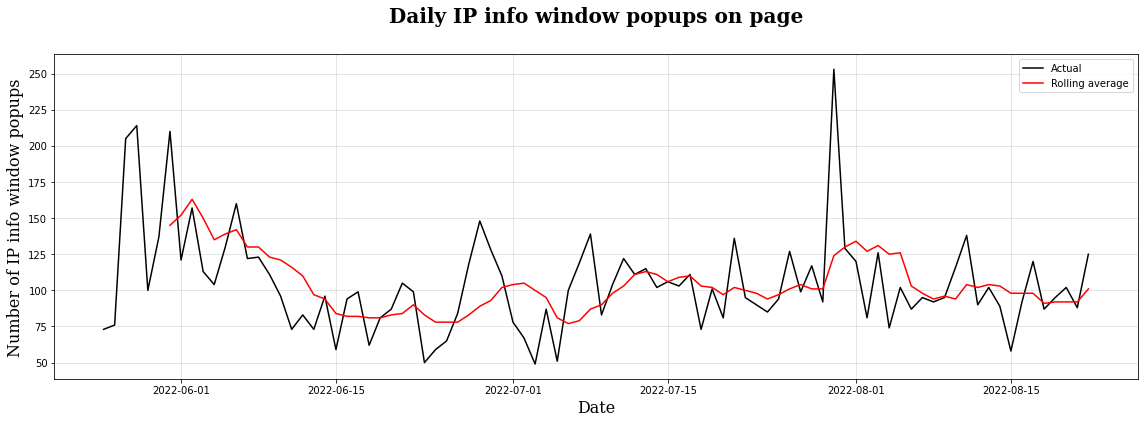

In [65]:
xlabel='Date'
ylabel='Number of IP info window popups'
title="Daily IP info window popups on page"
fig = plt.figure(facecolor='w', figsize=(16, 6))

ax = fig.add_subplot(111)
#fcst_t = df['y_m_d'].dt.to_pydatetime()
ax.plot(df['y_m_d'].dt.to_pydatetime(), df['ipinfo_popup'], 'k-', label='Actual')
ax.plot(df['y_m_d'].dt.to_pydatetime(), df['rolling_avg'],'r-', label='Rolling average')

ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_xlabel(xlabel, fontsize = 16, family='serif')
ax.set_ylabel(ylabel, fontsize = 16, family='serif')
ax.set_title(title,fontweight="bold",fontsize = 20, family='serif', y=1.08)


ax.legend(loc='upper right')
fig.tight_layout()


In [ ]:
plt.savefig("Figures_out/1_popup.png", facecolor='white', transparent=False)

__Average__ 

In [42]:
df['ipinfo_popup'].mean().round(2)

104.86

__Median__. 

In [40]:
np.percentile(df['ipinfo_popup'], 50)

99.0

__Note__   
Between 2022-05-25 and 2022-08-22, IP info popup was used 105 daily in average cross all wikis

### Top 5 wikis

In [102]:
query_popup_wiki ='''
SELECT concat(normalized_host.project, '.', normalized_host.project_class), count(1) AS popups, 
min(meta.dt) AS start_date, max(meta.dt) AS end_date 
FROM event.mediawiki_ipinfo_interaction
WHERE year=2022
AND event_action ='open_popup'
AND event_context ='page'
AND normalized_host.project NOT IN ('test', 'test2')
GROUP BY concat(normalized_host.project, '.', normalized_host.project_class)
ORDER BY popups DESC
LIMIT 100000
'''

In [103]:
df_wiki = hive.run(query_popup_wiki )

In [104]:
df_wiki

,_c0,popups,start_date,end_date
0,en.wikipedia,2470,2022-05-27T00:14:43.407Z,2022-08-25T01:55:01.297Z
1,ru.wikipedia,984,2022-05-27T12:57:33.379Z,2022-08-25T00:18:08.299Z
2,zh.wikipedia,675,2022-05-27T03:52:07.786Z,2022-08-25T01:26:03.277Z
3,fr.wikipedia,666,2022-05-31T00:22:49.244Z,2022-08-24T15:25:20.716Z
4,es.wikipedia,587,2022-05-29T13:09:26.563Z,2022-08-24T20:11:48.328Z
...,...,...,...,...
91,zh.wikivoyage,1,2022-07-17T13:31:26.748Z,2022-07-17T13:31:26.748Z
92,ja.wiktionary,1,2022-06-13T07:18:53.005Z,2022-06-13T07:18:53.005Z
93,lt.wikipedia,1,2022-07-13T20:56:21.755Z,2022-07-13T20:56:21.755Z
94,fr.wikiversity,1,2022-07-25T20:37:27.970Z,2022-07-25T20:37:27.970Z


__Note__   
 - Between 2022-05-27 and 2022-08-25, IP info popup has been used on 95 wiki projects.
 - Top 5 wikis which mostly used IP info are: en.wikipedia, ru.wikipedia, zh.wikipedia, fr.wikipedia, es.wikipedia


## How often is the accordion expanded/collapsed?


__IP info accordion collapsed__  
<img src="Figures/IP_info_accordion.png" width="400" height="300" align="center"/>

__IP info accordion expanded__  
<img src="Figures/IP_info_accordion_expanded.png" width="400" height="300" align="center"/>

In [107]:
query_accordion ='''
SELECT TO_DATE(meta.dt) AS y_m_d ,event_action ,  count(1) AS counts
FROM event.mediawiki_ipinfo_interaction
WHERE year=2022 
AND event_context ="infobox"
AND event_action IN ('collapse','expand')
AND normalized_host.project NOT IN ('test', 'test2')
GROUP BY TO_DATE(meta.dt), event_action
ORDER BY y_m_d
LIMIT 100000
'''

In [108]:
df_accordion =hive.run(query_accordion)

In [109]:
df_accordion

,y_m_d,event_action,counts
0,2022-05-27,expand,137
1,2022-05-27,collapse,64
2,2022-05-28,expand,100
3,2022-05-28,collapse,80
4,2022-05-29,expand,90
...,...,...,...
177,2022-08-23,collapse,57
178,2022-08-24,collapse,64
179,2022-08-24,expand,79
180,2022-08-25,collapse,2


In [110]:
df_accordion.loc[:, 'y_m_d']=pd.to_datetime(df_accordion['y_m_d']).copy()

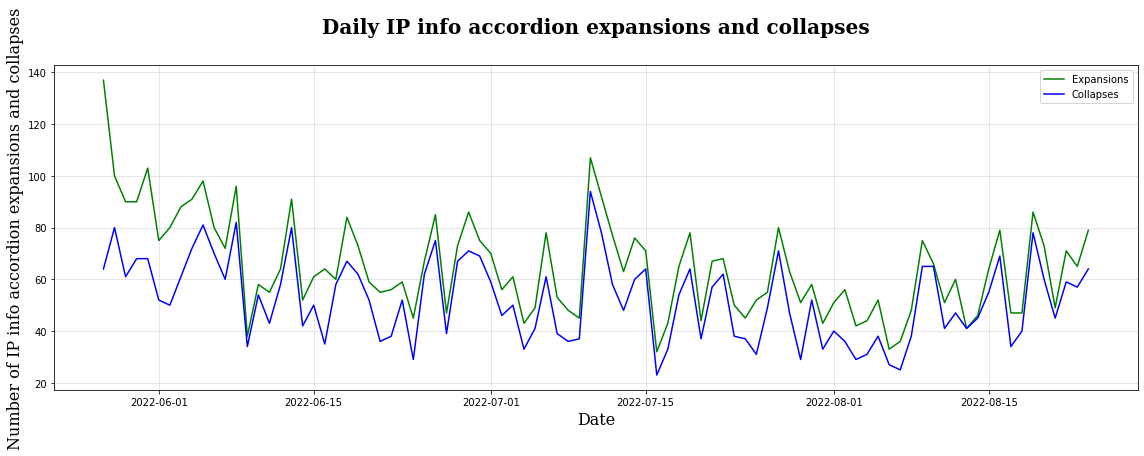

In [125]:
xlabel='Date'
ylabel='Number of IP info accordion expansions and collapses'
title="Daily IP info accordion expansions and collapses"
df_e=df_accordion[df_accordion.event_action=='expand'][:-1]
df_c=df_accordion[df_accordion.event_action=='collapse'][:-1]
fig = plt.figure(facecolor='w', figsize=(16, 6))

ax = fig.add_subplot(111)
#fcst_t = df['y_m_d'].dt.to_pydatetime()
ax.plot(df_e['y_m_d'].dt.to_pydatetime(), df_e['counts'], 'g-', label='Expansions')
ax.plot(df_c['y_m_d'].dt.to_pydatetime(), df_c['counts'],'b-', label='Collapses')

ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_xlabel(xlabel, fontsize = 16, family='serif')
ax.set_ylabel(ylabel, fontsize = 16, family='serif')
ax.set_title(title,fontweight="bold",fontsize = 20, family='serif', y=1.08)


ax.legend(loc='upper right')
fig.tight_layout()

__Note__. 

- The number of clicks to expand is relatively higher than the number of clicks to collapse. 
- The trends of expansions and collapses are correlated well. 

## How often is the accordion opened *after* the popup was opened?


User flow: Click on any place of the popup leads to contribution page with the accordion 
<img src="Figures/IP_info_popup_on_page_click.png" width="400" height="300" align="center"/>  

Click rate of the link on popup to open the accordion(Special:Contribs page) = # of clicks on the link on popup to open the accordion/ # of clicks on "i" icon by the IP to popup 


In [112]:
query_click_rate =  '''
WITH t_i AS
(SELECT 
concat(normalized_host.project, '.', normalized_host.project_class) AS wiki, 
count(1) AS ipinfo_popups
FROM event.mediawiki_ipinfo_interaction
WHERE year=2022 
AND event_action ="open_popup"
AND event_context ="page"
AND normalized_host.project NOT IN ('test', 'test2')
GROUP BY 
concat(normalized_host.project, '.', normalized_host.project_class)
),
t_c AS
(
SELECT 
concat(normalized_host.project, '.', normalized_host.project_class) AS wiki, 
count(1) AS clicks_on_popup
FROM event.mediawiki_ipinfo_interaction
WHERE year=2022 
AND event_action ="open_infobox"
AND event_context ="popup"
AND normalized_host.project NOT IN ('test', 'test2')
GROUP BY 
concat(normalized_host.project, '.', normalized_host.project_class)
)
SELECT t_i.wiki, t_i.ipinfo_popups, t_c.clicks_on_popup
FROM t_i LEFT JOIN t_c ON t_i.wiki=t_c.wiki
ORDER BY t_i.ipinfo_popups DESC
LIMIT 100000
'''


In [113]:
df_click_rate=hive.run(query_click_rate)

In [114]:
df_click_rate.head(10)

,wiki,ipinfo_popups,clicks_on_popup
0,en.wikipedia,2470,32.0
1,ru.wikipedia,984,25.0
2,zh.wikipedia,675,22.0
3,fr.wikipedia,666,24.0
4,es.wikipedia,587,1.0
5,it.wikipedia,303,1.0
6,th.wikipedia,294,1.0
7,tr.wikipedia,250,3.0
8,commons.wikimedia,203,1.0
9,he.wikipedia,200,7.0


In [ ]:
df_click_rate[np.isnan(df_click_rate.clicks_on_popup)] = 0

Cilcks/Popups

In [117]:
df_click_rate.clicks_on_popup.sum()/df_click_rate.ipinfo_popups.sum()

0.02250466417910448

__Note__  

2.3% of IP info popups lead to a click for the accordion. To check with PM.

This feature is not obvious to a new user. 

## How often is limited view shown? How often is full view shown?

In [118]:
query_version =  '''
SELECT TO_DATE(meta.dt) AS y_m_d , event_ipinfo_version, count(1) AS ipinfo_popup
FROM event.mediawiki_ipinfo_interaction
WHERE year=2022 
AND event_action ="open_popup"
AND event_context ="page"
AND normalized_host.project NOT IN ('test', 'test2')
GROUP BY TO_DATE(meta.dt), event_ipinfo_version
ORDER BY y_m_d
LIMIT 100000
'''

In [119]:
df_version=hive.run(query_version)

In [120]:
df_version

,y_m_d,event_ipinfo_version,ipinfo_popup
0,2022-05-27,full,66
1,2022-05-27,basic,139
2,2022-05-28,full,52
3,2022-05-28,basic,162
4,2022-05-29,full,35
...,...,...,...
177,2022-08-23,basic,36
178,2022-08-24,basic,55
179,2022-08-24,full,51
180,2022-08-25,basic,1


__Total popups__

In [121]:
df_version.ipinfo_popup.sum()

9466

__Popups in full verion/total popups__

In [122]:
df_version[df_version.event_ipinfo_version=='full'].ipinfo_popup.sum()/9468

0.44243768483312207

__Popups in basic version/total popups__

In [123]:
df_version[df_version.event_ipinfo_version=='basic'].ipinfo_popup.sum()/9468

0.5573510773130546

__Note__  

Between 2022-05-27 and 2022-08-25, 44% popups show full version, 56% popups show basic version


# What is the usage of the popup on the different pages where it is exposed?
IP info feature was enabled on following four types of pages:   
__1.revision action history page__  
<img src="Figures/IP_info_popup_on_page.png" width="400" height="300" align="center"/>  
<br /> 
__2.Special:Log page__  
<img src="Figures/special_log.png" width="400" height="300" align="center"/>  
<br /> 
__3.Special:RecentChanges page__  
<img src="Figures/special_recentchanges.png" width="400" height="300" align="center"/>  
<br /> 
__4.Special:watchlist page__  
<img src="Figures/special_watchlist.png" width="400" height="300" align="center"/>  
<br /> 
Note: Special:Contributions : do not have show popups. It's expected.    


In [126]:
query_source =  '''
SELECT TO_DATE(meta.dt) AS y_m_d ,event_source, count(1) AS ipinfo_popup
FROM event.mediawiki_ipinfo_interaction
WHERE year=2022 
AND event_action ="open_popup"
AND event_context ="page"
AND normalized_host.project NOT IN ('test', 'test2')
GROUP BY TO_DATE(meta.dt),event_source
ORDER BY y_m_d
LIMIT 100000
'''

In [127]:
df_source =hive.run(query_source)

In [132]:
df_source.loc[:, 'y_m_d']=pd.to_datetime(df_source['y_m_d']).copy()
df_source

,y_m_d,event_source,ipinfo_popup
0,2022-05-27,special_recentchanges,52
1,2022-05-27,action_history,96
2,2022-05-27,special_watchlist,51
3,2022-05-27,special_log,6
4,2022-05-28,action_history,137
...,...,...,...
342,2022-08-24,action_history,48
343,2022-08-25,action_history,54
344,2022-08-25,special_log,3
345,2022-08-25,special_recentchanges,26


In [144]:
df_source[df_source.event_source=='special_contributions'][:-1]

,y_m_d,event_source,ipinfo_popup


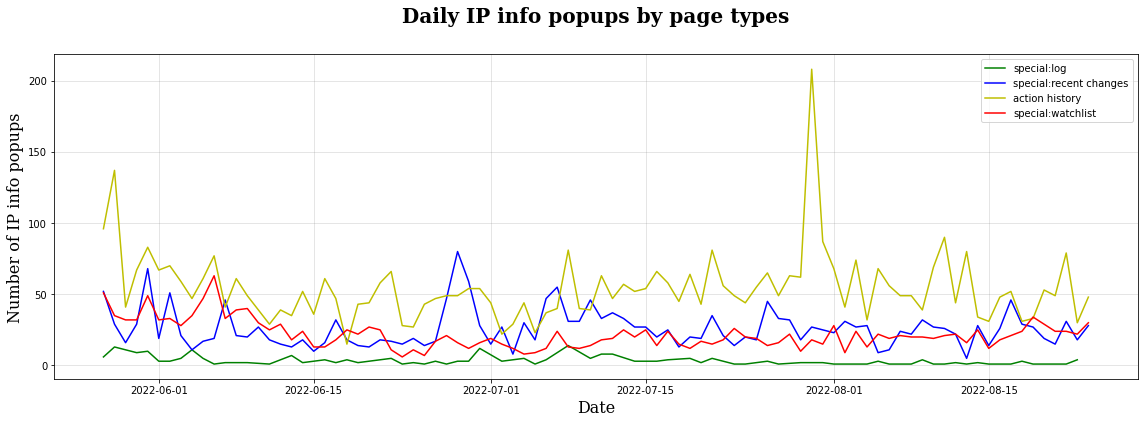

In [134]:
xlabel='Date'
ylabel='Number of IP info popups'
title="Daily IP info popups by page types"
df_l=df_source[df_source.event_source=='special_log'][:-1]
df_r=df_source[df_source.event_source=='special_recentchanges'][:-1]
df_h=df_source[df_source.event_source=='action_history'][:-1]
df_w=df_source[df_source.event_source=='special_watchlist'][:-1]

fig = plt.figure(facecolor='w', figsize=(16, 6))

ax = fig.add_subplot(111)
#fcst_t = df['y_m_d'].dt.to_pydatetime()
ax.plot(df_l['y_m_d'].dt.to_pydatetime(), df_l['ipinfo_popup'], 'g-', label='special:log')
ax.plot(df_r['y_m_d'].dt.to_pydatetime(), df_r['ipinfo_popup'],'b-', label='special:recent changes')
ax.plot(df_h['y_m_d'].dt.to_pydatetime(), df_h['ipinfo_popup'], 'y-', label='action history')
ax.plot(df_w['y_m_d'].dt.to_pydatetime(), df_w['ipinfo_popup'],'r-', label='special:watchlist')

ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_xlabel(xlabel, fontsize = 16, family='serif')
ax.set_ylabel(ylabel, fontsize = 16, family='serif')
ax.set_title(title,fontweight="bold",fontsize = 20, family='serif', y=1.08)


ax.legend(loc='upper right')
fig.tight_layout()

In [139]:
df_sum=df_source.groupby('event_source').sum()

In [140]:
df_sum

,ipinfo_popup
event_source,
action_history,4939
special_log,260
special_recentchanges,2371
special_watchlist,2008


In [141]:
df_source.ipinfo_popup.sum()

9578

In [142]:
df_sum['share_in_pct']=round(df_sum['ipinfo_popup']/df_source.ipinfo_popup.sum(),4) *100

In [143]:
df_sum

,ipinfo_popup,share_in_pct
event_source,,
action_history,4939,51.57
special_log,260,2.71
special_recentchanges,2371,24.75
special_watchlist,2008,20.96


__Note__ 

Between 2022-05-27 and 2022-08-25,   
- 51.57% popups are from action_history page.
- 24.75% popups are from special:recentchanges pages.
- 20.96% popups are from special:watchlist pages. 
- Only 2.71% popups are from special:log pages.

# Do people understand the information being shown?
Is the "help" for the information accessed by users?
<img src="Figures/IP_info_accordion_expanded.png" width="400" height="300" align="center"/>

In [148]:
query_help =  '''
SELECT TO_DATE(meta.dt) AS y_m_d , event_action, count(1) AS clicks
FROM event.mediawiki_ipinfo_interaction
WHERE year=2022 
AND event_action LIKE 'click_help%'
AND event_context = 'infobox'
AND normalized_host.project NOT IN ('test', 'test2')
GROUP BY TO_DATE(meta.dt), event_action
ORDER BY y_m_d
LIMIT 100000
'''

In [149]:
df_help = hive.run(query_help)

In [152]:
df_help.loc[:, 'y_m_d']=pd.to_datetime(df_help['y_m_d']).copy()
df_help

,y_m_d,event_action,clicks
0,2022-05-28,click_help_proxy,13
1,2022-05-28,click_help_connection_method,8
2,2022-05-28,click_help_connection_owner,16
3,2022-05-29,click_help_connection_method,9
4,2022-05-29,click_help_connection_owner,14
...,...,...,...
250,2022-08-25,click_help_connection_owner,4
251,2022-08-25,click_help_connection_method,5
252,2022-08-26,click_help_connection_method,1
253,2022-08-26,click_help_connection_owner,2


In [153]:
df_help

,y_m_d,event_action,clicks
0,2022-05-28,click_help_proxy,13
1,2022-05-28,click_help_connection_method,8
2,2022-05-28,click_help_connection_owner,16
3,2022-05-29,click_help_connection_method,9
4,2022-05-29,click_help_connection_owner,14
...,...,...,...
250,2022-08-25,click_help_connection_owner,4
251,2022-08-25,click_help_connection_method,5
252,2022-08-26,click_help_connection_method,1
253,2022-08-26,click_help_connection_owner,2


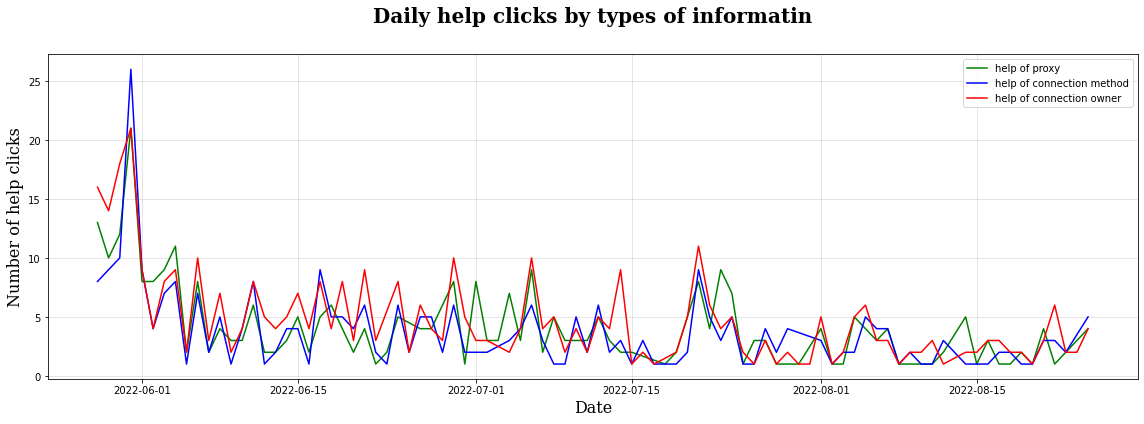

In [155]:
xlabel='Date'
ylabel='Number of help clicks'
title="Daily help clicks by types of informatin"
df_p=df_help[df_help.event_action=='click_help_proxy'][:-1]
df_m=df_help[df_help.event_action=='click_help_connection_method'][:-1]
df_o=df_help[df_help.event_action=='click_help_connection_owner'][:-1]


fig = plt.figure(facecolor='w', figsize=(16, 6))

ax = fig.add_subplot(111)
#fcst_t = df['y_m_d'].dt.to_pydatetime()
ax.plot(df_p['y_m_d'].dt.to_pydatetime(), df_p['clicks'], 'g-', label='help of proxy')
ax.plot(df_m['y_m_d'].dt.to_pydatetime(), df_m['clicks'],'b-', label='help of connection method')
ax.plot(df_o['y_m_d'].dt.to_pydatetime(), df_o['clicks'], 'r-', label='help of connection owner')


ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_xlabel(xlabel, fontsize = 16, family='serif')
ax.set_ylabel(ylabel, fontsize = 16, family='serif')
ax.set_title(title,fontweight="bold",fontsize = 20, family='serif', y=1.08)


ax.legend(loc='upper right')
fig.tight_layout()

In [156]:
df_help_sum=df_help.groupby('event_action').sum()

__Total clicks on help 'i'__

In [ ]:
df_help_sum['share_in_pct']=round(df_help_sum['clicks']/df_help.clicks.sum(),4) *100

In [159]:
df_help_sum

,clicks,share_in_pct
event_action,,
click_help_connection_method,315,29.72
click_help_connection_owner,406,38.30
click_help_proxy,339,31.98


__Note__.   
Between 2022-5-28 and 2022-8-26, 
- Help of connection_owner is mostly clicked. 38.3% of chicks on help are for the info pf connection owner
- Connection method and proxy are equally popular. 
- Help of ASN was not tracked in current instrumentation. To check with AHT team


# Who is the information shown most to?
This can help us assess if we can limit the exposure of the tool. We can measure the edit count bucket for users who are using this tool (while anonymizing their ID). The account age was not captured in data instrumentation. 

## IP info popup

In [179]:
query_popup_edit_bucket =  '''
SELECT user_edit_bucket, count(1) AS ipinfo_popup
FROM event.mediawiki_ipinfo_interaction
WHERE year=2022 
AND event_action ="open_popup"
AND event_context ="page"
AND normalized_host.project NOT IN ('test', 'test2')
GROUP BY user_edit_bucket
ORDER BY ipinfo_popup DESC
LIMIT 100000
'''

In [180]:
df_popup_edit_bucket =hive.run(query_popup_edit_bucket)

In [181]:
df_popup_edit_bucket

,user_edit_bucket,ipinfo_popup
0,1000+ edits,8915
1,100-999 edits,619
2,5-99 edits,118
3,0 edits,3
4,1-4 edits,3


## IP info accordion

In [165]:
query_accordion_edit_bucket ='''
SELECT user_edit_bucket,   count(1) AS counts
FROM event.mediawiki_ipinfo_interaction
WHERE year=2022 
AND event_context ="infobox"
AND event_action IN ('collapse','expand')
AND normalized_host.project NOT IN ('test', 'test2')
GROUP BY  user_edit_bucket
ORDER BY counts DESC
LIMIT 100000
'''

In [166]:
df_accordion_edit_bucket =hive.run(query_accordion_edit_bucket)

In [167]:
df_accordion_edit_bucket

,user_edit_bucket,counts
0,1000+ edits,9475
1,100-999 edits,773
2,5-99 edits,204
3,1-4 edits,37
4,0 edits,31


__Note:__  
    
IP info is mostly used by experienced editors who had more than 1000 edits.

# Opt-in / opt-out
__Opt-in on user contributions page__  
<img src="Figures/enable_contributions_page.png" width="400" height="300" align="center"/>  
<br />
__Opt-in or opt-out on preference page__  
<img src="Figures/enable_pref_page.png" width="400" height="300" align="center"/>  
<br />
## Activation/Deactivation rate for the feature


### Activation rate for the feature

In [257]:
query_enable = '''
SELECT  event_source,event_action , count(1) AS events,
min(meta.dt) AS start_date, max(meta.dt) AS end_date
FROM event.mediawiki_ipinfo_interaction
WHERE year=2022 
AND event_action IN ("init_disclaimer" ,"accept_disclaimer","close_disclaimer", "uncheck_iagree", 
                       "enable_ipinfo" ,"disable_ipinfo"  )
AND normalized_host.project NOT IN ('test', 'test2')
GROUP BY event_source,event_action 

'''

In [258]:
df_enable=hive.run(query_enable)

In [259]:
df_enable

,event_source,event_action,events,start_date,end_date
0,special_contributions,accept_disclaimer,523,2022-06-03T15:49:17.154Z,2022-09-01T11:43:21.823Z
1,special_contributions,close_disclaimer,2137,2022-06-03T13:31:01.985Z,2022-09-01T12:39:26.928Z
2,special_contributions,init_disclaimer,2620,2022-06-03T13:04:35.303Z,2022-09-01T12:59:26.527Z
3,special_preferences,accept_disclaimer,2221,2022-06-03T13:22:58.879Z,2022-09-01T12:55:24.256Z
4,special_preferences,disable_ipinfo,369,2022-06-03T18:40:44.722Z,2022-09-01T00:19:45.544Z
5,special_preferences,enable_ipinfo,2225,2022-06-03T13:22:58.884Z,2022-09-01T12:55:24.268Z
6,special_preferences,uncheck_iagree,363,2022-06-03T18:40:44.717Z,2022-09-01T00:19:45.540Z


### Activate rate
#### Definition1:  number of times users clicked "enable IP info tool"/ number of times users see the disclaimer

In [261]:
2225/2620

0.8492366412213741

__Note__.   
Activation rate is 84.9%

Need to check with PM and engineer about what kind of events are recorded with key  `event_source=special_preferences & event_action=enable_ipinfo`  , from contribution page or from the preference page (above picture), or from both. If it's `both`, the activation rate using definition1 is over-counted and not accurate.

#### Definition2: number of times users accept disclaimer / number of times the disclaimer shown

In [262]:
523/2620

0.19961832061068702

__Note__   
Activation rate is 20% under definition2

### Deactivate rate
Definition: number of times users disabled "IP info tool" / number of times users enabled "IP info tool"

In [235]:
379/2391

0.15851108322877458

__Note__. 

Deactivate rate is 15.6% 

## How many times do people see the disclaimer? How many times do people accept the terms of the disclaimer? How many times do people churn away?

In [245]:
query_disclaimer = '''
SELECT  event_source,event_action , count(1) AS events, min(meta.dt) AS start_date, max(meta.dt) AS end_date 
FROM event.mediawiki_ipinfo_interaction
WHERE year=2022 
AND event_action IN ("init_disclaimer" ,"accept_disclaimer","close_disclaimer"  )
AND normalized_host.project NOT IN ('test', 'test2')
GROUP BY event_source,event_action 
'''

In [211]:
df_disclaimer =hive.run(query_disclaimer)

In [213]:
df_disclaimer 

,event_source,event_action,events,start_date,end_date
0,special_contributions,accept_disclaimer,607,2022-05-31T00:29:32.625Z,2022-09-01T00:19:39.740Z
1,special_contributions,close_disclaimer,2194,2022-05-31T00:41:44.487Z,2022-09-01T01:36:21.863Z
2,special_contributions,init_disclaimer,2756,2022-05-31T00:27:18.137Z,2022-09-01T01:36:21.841Z
3,special_preferences,accept_disclaimer,2387,2022-05-31T00:01:10.979Z,2022-09-01T00:19:22.511Z


__Acceptance rate__

In [233]:
#Accept rate
607/2756


0.2202467343976778

__Churn rate__ 

In [234]:
#churn rate
2194/2756

0.7960812772133526

accept_disclaimer + close_disclaimer

In [230]:
607+2194

2801

? On special contribution page

accept_disclaimer + close_disclaimer > init_disclaimer

__Note__ 

Between 2022-05-31 and 2022-09-01   
__On Special contribution page:__   
The disclaimer showed 2753 times.  
The disclaimer was accepted 607 times, acceptance rate 22%.   
2194 times, people churn away by closing the disclaimer without any clicks, churn rate 80%.  

On special contribution page, accept_disclaimer + close_disclaimer > init_disclaimer.   Possible reason:1)User might click accept disclaimer multiple times after one initialization ; 2) Current calculation is an estimation. For the users who accept disclaimer, if their initial events are beyond 90 days, the initial events are not available in schema any more. Same for accepting events. For the users who have seen the disclaimer and have not accepted yet, only initial_disclaimer events are available in the schema. We don't track user ID or session ID, therefore, we cannot connect the user's journey by any identity. (see below exploration) 

__On preference page:__   
The disclaimer was accepted 2387 times.

To check with the PM and engineer about no initial events on the preference page.


__Exploration__   
Below query doesn't return any events because meta.id is not session id. We don't record user ID or session id in schema. Therefore, we don’t have any identity to connect the user's journey.

In [254]:
query_disclaimer_2 = '''
SELECT   t1.meta.id, t1.meta.dt AS init_ds, t2.event_action,  t2.meta.dt AS action_ds
FROM event.mediawiki_ipinfo_interaction AS t1
LEFT JOIN event.mediawiki_ipinfo_interaction AS t2 
ON t1.meta.id=t2.meta.id 
AND t1.normalized_host.project=t2.normalized_host.project 
AND t1.normalized_host.project_class=t2.normalized_host.project_class
--AND t1.meta.dt < t2.meta.dt
AND t1.year=t2.year
WHERE t1.year=2022 
AND t1.event_action="init_disclaimer" AND t2.event_action IN ("accept_disclaimer","close_disclaimer")
AND t1.normalized_host.project NOT IN ('test', 'test2')
'''

In [255]:
df_disclaimer_2=hive.run(query_disclaimer_2)

In [256]:
df_disclaimer_2

,id,init_ds,event_action,action_ds


# Other interesting findings

## How often the IP address was copied?

In [240]:
query_copy= '''
SELECT event_action, event_context, event_source, count(1) AS events
FROM event.mediawiki_ipinfo_interaction
WHERE year=2022 AND normalized_host.project NOT IN ('test', 'test2')
AND event_action='copy'
AND event_context='ip_address'
GROUP BY event_action, event_context, event_source
'''

In [241]:
df_copy = hive.run(query_copy)

In [242]:
df_copy

,event_action,event_context,event_source,events
0,copy,ip_address,action_history,431
1,copy,ip_address,special_contributions,4139
2,copy,ip_address,special_log,37
3,copy,ip_address,special_recentchanges,258
4,copy,ip_address,special_watchlist,65


In [249]:
df_copy['share_in_pct']=round(df_copy['events']/df_copy.events.sum(),4) *100

In [250]:
df_copy

,event_action,event_context,event_source,events,share_in_pct
0,copy,ip_address,action_history,431,8.74
1,copy,ip_address,special_contributions,4139,83.96
2,copy,ip_address,special_log,37,0.75
3,copy,ip_address,special_recentchanges,258,5.23
4,copy,ip_address,special_watchlist,65,1.32


__Note__. 

Bewteen 2022-05-31 and 2022-09-01

84% of IP copy events are from special contributions pages.  
8.74% of IP copy events are from revision action history pages.  
5.23% of IP copy events are from special recentchanges pages.  
1.32% of IP copy events are from special watchlist pages.  
Only 0.75% of IP copy events are from specal log pages.  